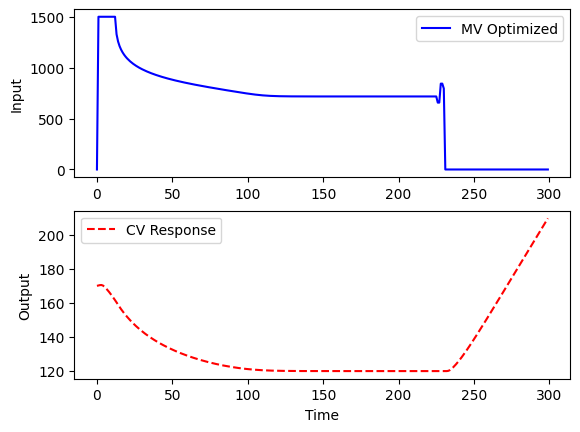

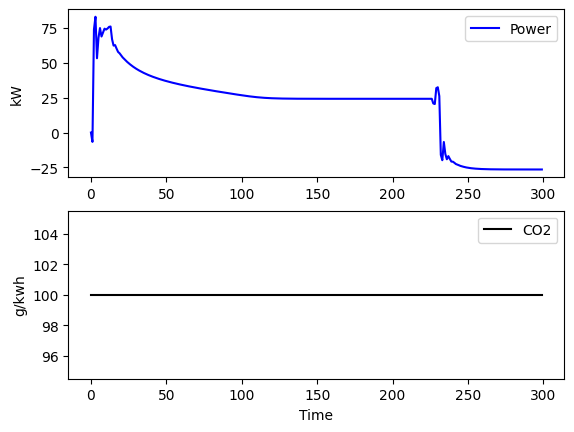

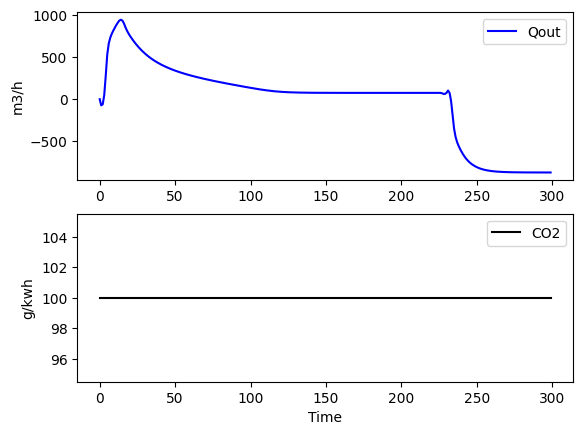

In [11]:
from gekko import GEKKO
import numpy as np
from random import random
import matplotlib.pyplot as plt
%matplotlib inline

m = GEKKO()
#time horizon: 6h
Thor = 5*60 #sec
Ts = 1 #sec
m.time = np.linspace(0,int(Thor-1),int(Thor/Ts))
n = Ts*Thor

#m.time = np.linspace(0,301,300)

# Parameters
mass = 500
b = m.Param(value=50)
K = m.Param(value=0.8)

# Manipulated variable
w = m.MV(value=0, lb = 0, ub = 1500)
w.STATUS = 1  # allow optimizer to change
#w.DCOST = 0.1 # smooth out gas pedal movement
#w.DMAX = 20   # slow down change of gas pedal

# Controlled Variable
Qout = m.CV(value=0)
P = m.CV(value=0)
h = m.CV(value=170)
#h.STATUS = 1  # add the SP to the objective
#m.options.CV_TYPE = 2 # squared error
#h.SP = 120     # set point
#h.TR_INIT = 1 # set point trajectory
#h.TAU = 5     # time constant of trajectory

m.options.CV_TYPE = 1
eH = m.CV(value=0)
eH.SPHI=0         #Set point high for linear error model.
eH.WSPHI=100        #Objective function weight on upper set point for linear error model.
eH.WSPLO=0        # Objective function weight on lower set point for linear error model
eH.STATUS =1      # eH : Error is considered in the objective function.

eL = m.CV(value=0)
eL.SPLO=0
eL.WSPHI=0
eL.WSPLO=1000
eL.STATUS = 1    

# CO2 Values
#co2 = np.random.randint(70,100,size=n)
x_values = np.linspace(0, 2 * np.pi, 300)
y_values = np.sin(x_values)
noise_factor = 0.1
co2 = y_values + noise_factor * np.random.normal(size=len(y_values))
co2 = 100*np.ones(n)


c = m.Param(value=co2)
m.Minimize(c*P)

# Process model
#m.Equation(mass*h.dt() == -v*b + K*b*p)

A_power = np.array([[3.7971E-01],\
                    [5.1151E-02],\
                    [3.1656E-01]])
A_outflow = np.array([[1.2995],\
                    [-4.3918E-01],\
                    [4.5231E-02],\
                    [0],\
                    [1.0387E-02]])

# B (ny x (nb x nu))
B_power = np.array([[[5.5404E-02],[-1.4118E-02],[-2.3452E-02]]]).T
B_outflow = np.array([[[7.1049E-02],[4.1327E-02],[6.4801E-02],[0],[-6.6199E-02]]]).T

C_power = np.array([-6.6831])
C_outflow = np.array([-7.3292E+01])

p_power = {'a':A_power,'b':B_power,'c':C_power}
p_outflow = {'a':A_outflow,'b':B_outflow,'c':C_outflow}

m.arx(p_power,P,w)
m.arx(p_outflow,Qout,w)

m.Equation(h.dt() == 1/18 *(75 - Qout)/3600*100)
dh = m.Var()
m.Equation(h.dt() == dh*100)
m.Equations([eH==h-160,eL==h-120]) # Errors


m.options.IMODE = 6 # control
m.solve(disp=False)

# get additional solution information
import json
with open(m.path+'//results.json') as f:
    results = json.load(f)

plt.figure()
plt.subplot(2,1,1)
plt.plot(m.time,w.value,'b-',label='MV Optimized')
plt.legend()
plt.ylabel('Input')
plt.subplot(2,1,2)
#plt.plot(m.time,results['v3.sp'],'k-',label='Reference Trajectory')
plt.plot(m.time,h.value,'r--',label='CV Response')
plt.ylabel('Output')
plt.xlabel('Time')
plt.legend(loc='best')

plt.figure()
plt.subplot(2,1,1)
plt.plot(m.time,P.value,'b-',label='Power')
plt.legend()
plt.ylabel('kW')
plt.subplot(2,1,2)
plt.plot(m.time,c.Value,'k-',label='CO2')
plt.ylabel('g/kwh')
plt.xlabel('Time')
plt.legend(loc='best')

plt.figure()
plt.subplot(2,1,1)
plt.plot(m.time,Qout.value,'b-',label='Qout')
#plt.plot(m.time,Qin_hat*,'g-',label='Qout')
plt.legend()
plt.ylabel('m3/h')
plt.subplot(2,1,2)
plt.plot(m.time,c.Value,'k-',label='CO2')
plt.ylabel('g/kwh')
plt.xlabel('Time')
plt.legend(loc='best')
